In [1]:
import shutil
import os


directory = '__pycache__'
if os.path.exists(directory):
    shutil.rmtree(directory)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import sys
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm.notebook import tqdm
from dataset import CityScapesDataset
from PIL import ImageShow
import matplotlib.pyplot as plt

from unet import UNet
from dataset import UnetDataSet
from utils import load_checkpoint, save_checkpoint, get_loaders, save_checkpoint, get_scores, get_transforms

# Hyperparameters

In [3]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 128
IMAGE_WIDTH = IMAGE_HEIGHT
MAX_BATCH = None
PIN_MEMORY = True
LOAD_MODEL = True


## Carvana Dataset Directories

In [4]:
TRAIN_IMG_DIR = "F:\\UNI_STUFF\\Thesis\\UnetDatatset\\train"
TRAIN_MASK_DIR = "F:\\UNI_STUFF\\Thesis\\UnetDatatset\\train_masks"
VAL_IMG_DIR = "F:\\UNI_STUFF\\Thesis\\UnetDatatset\\val"
VAL_MASK_DIR = "F:\\UNI_STUFF\\Thesis\\UnetDatatset\\val_masks"

## Semantic Segmentation for Self Driving Cars


In [5]:
image_dir = ["I:/Downloads/Compressed/DATA/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_dir = ["I:/Downloads/Compressed/DATA/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

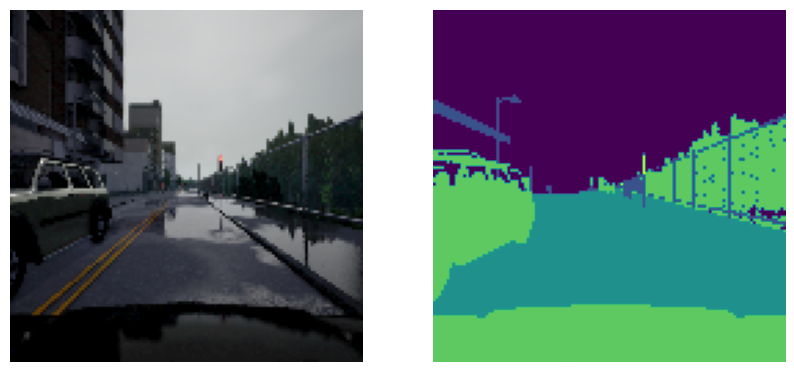

In [6]:
dataset = UnetDataSet(image_dir, mask_dir, transform=
                            A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
    ]
))


img, mask = dataset[0]

mask = np.longlong(mask)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(mask)
plt.show()

## The training function

In [7]:
def train_fn(epoch, loader, model, optimizer, loss_fn, scaler, autocast=None):
    
    loop = tqdm(loader, desc=f"Training...Epoch {epoch}: ", unit="batch")

    for batch_idx, (image, mask) in enumerate(loop):
        
        image = image.to(device=DEVICE)
        mask = mask.long().to(device=DEVICE)
        
        # forward
        optimizer.zero_grad()
        if autocast:
            with autocast():
                predictions = model(image)
                loss = loss_fn(predictions, mask)
        else:
            predictions = model(image)
            loss = loss_fn(predictions, mask)
            score = get_scores(predictions, mask)
            acc = score['pixel_acc']
            iou = score['mIoU']
        
        # backward
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()

        
        # update tqdm loop
        loop.set_postfix({
            "loss": loss.item(), 
            "acc": acc.item(), 
            "iou": iou.item()}
            )

        torch.cuda.empty_cache()
    return predictions, mask, loss

In [8]:
model = UNet(in_channels=3, out_channels=13).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
start_epoch = 0

try:
    if LOAD_MODEL:
        start_epoch = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)
except Exception as e:
    print(f"Error loading checkpoint: {str(e)}")
    start_epoch = 0

full_dataset = UnetDataSet(image_dir, mask_dir, transform=get_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
torch.manual_seed(42)
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader, val_loader = get_loaders(
    train_ds,
    val_ds,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
)

Error loading checkpoint: [Errno 2] No such file or directory: 'my_checkpoint.pth.tar'


# Training Loop

Training...Epoch 1:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 1 is complete
=> Saving checkpoint


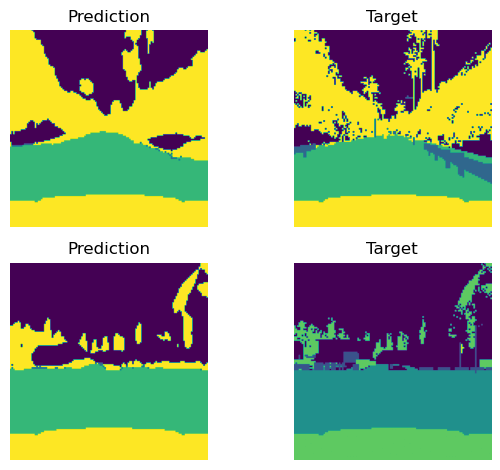

Training...Epoch 2:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 2 is complete
=> Saving checkpoint


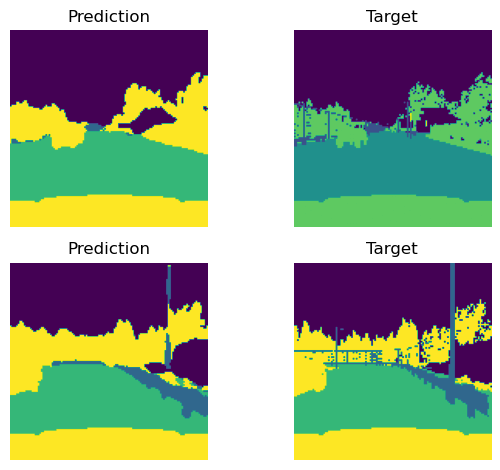

Training...Epoch 3:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 3 is complete
=> Saving checkpoint


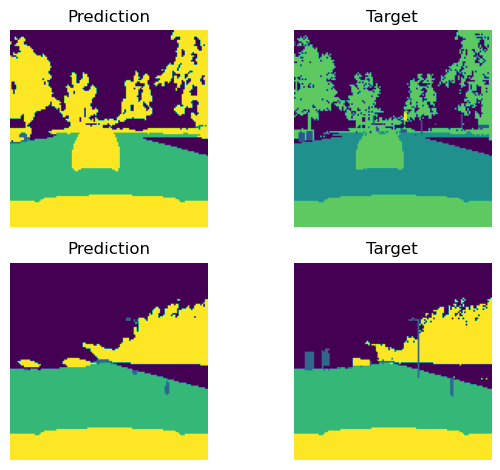

Training...Epoch 4:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 4 is complete
=> Saving checkpoint


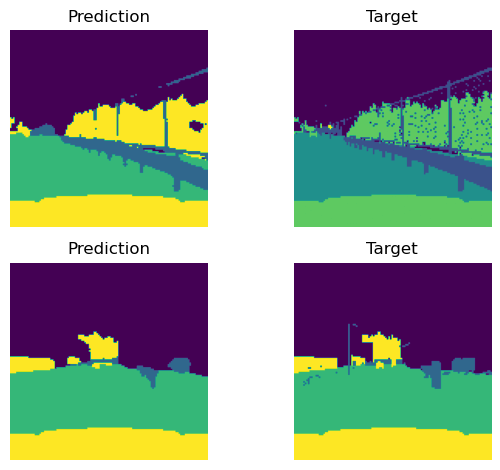

Training...Epoch 5:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 5 is complete
=> Saving checkpoint


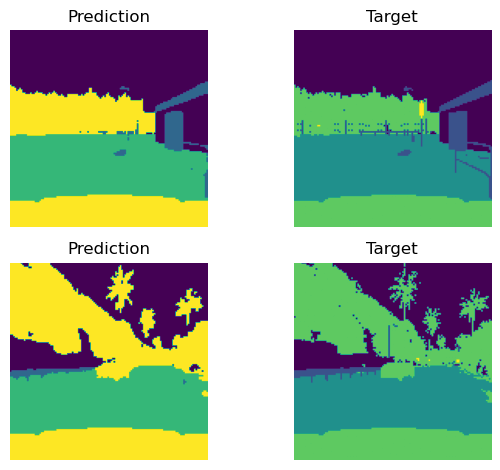

Training...Epoch 6:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 6 is complete
=> Saving checkpoint


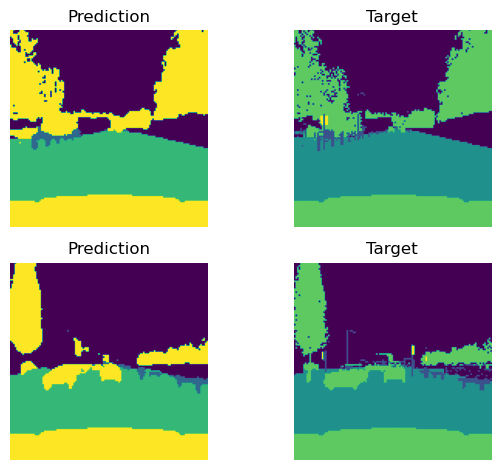

Training...Epoch 7:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 7 is complete
=> Saving checkpoint


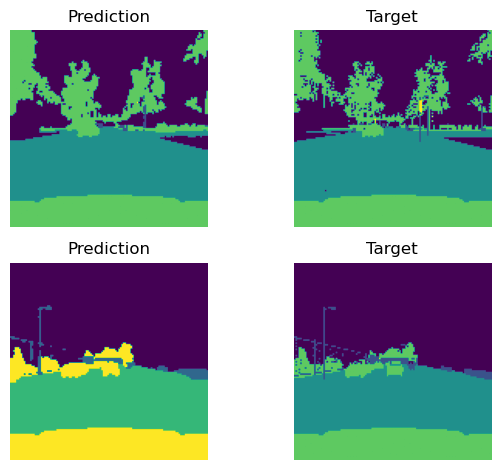

Training...Epoch 8:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 8 is complete
=> Saving checkpoint


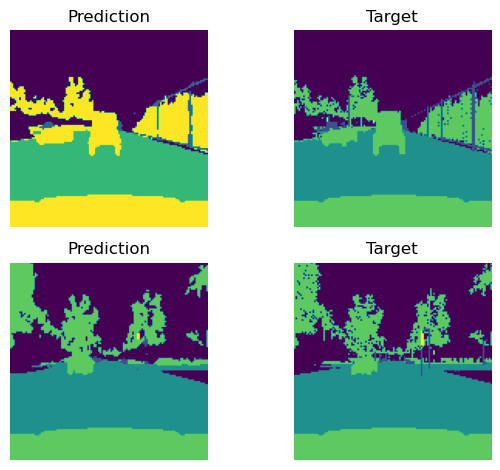

Training...Epoch 9:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 9 is complete
=> Saving checkpoint


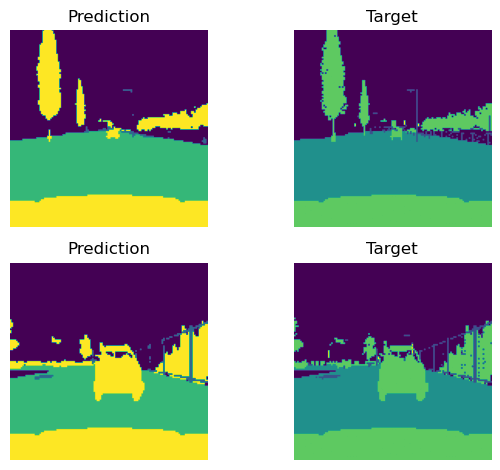

Training...Epoch 10:   0%|          | 0/250 [00:00<?, ?batch/s]

=> Epoch 10 is complete
=> Saving checkpoint


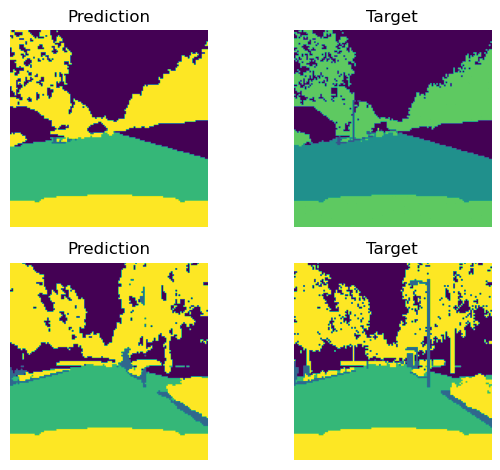

In [9]:
scaler = torch.cuda.amp.GradScaler(init_scale=2**16, growth_interval=2000)

start_epoch += 1 # start from the next epoch
for epoch in range(start_epoch, NUM_EPOCHS + 1):
    predictions, mask, loss = train_fn(epoch, train_loader, model, optimizer, loss_fn, scaler)
    
    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "epoch": epoch,
    }
    print(f"=> Epoch {epoch} is complete")
    save_checkpoint(checkpoint)

    # Clear cache after each epoch
    torch.cuda.empty_cache()

    #plot some examples to see how well the model is doing with matplotlib

    import matplotlib.pyplot as plt

    try:

        """Plotting the first prediction and target"""
        
        predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
        predictions = predictions.unsqueeze(1)
        mask = mask.unsqueeze(1)
        
        plt.subplot(2, 2, 1)
        plt.imshow(predictions[0][0].cpu().detach().numpy())
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(mask[0][0].cpu().detach().numpy())
        plt.title('Target')
        plt.axis('off')

        # Plotting the second prediction and target
        plt.subplot(2, 2, 3)
        plt.imshow(predictions[1][0].cpu().detach().numpy())
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(mask[1][0].cpu().detach().numpy())
        plt.title('Target')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")
        continue


In [10]:
import torch
from unet import UNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [20]:


# Load the model from the checkpoint
model = UNet(in_channels=3, out_channels=13)
checkpoint = torch.load("my_checkpoint.pth.tar")
model.load_state_dict(checkpoint["state_dict"])
model.eval()

transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize( 
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,), # Example normalization values
    ToTensorV2()
])

# Load and preprocess the image
image_dir = "I:\\Downloads\\Compressed\\DATA\\dataB\\dataB\\CameraRGB\\F70-3.png"
# image_path = "I:\\Downloads\\Compressed\\test\\fff013bbf988_08.jpg"
# image_path = "I:\\Downloads\\Compressed\\test\\fff341f26a19_04.jpg"
# image_path = "I:\\Downloads\\Compressed\\test\\83bfd5bb1286_03.jpg"
image = np.array(Image.open(image_dir).convert("RGB"))
image = transform(image=image)["image"].unsqueeze(0)
# input_tensor = val_transforms(image=image)["image"].unsqueeze(0)

# Make predictions
with torch.no_grad():
    predictions = model(image)

# Process the predictions as needed
# ...

# Print the predictions
predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
predictions = predictions.unsqueeze(1)


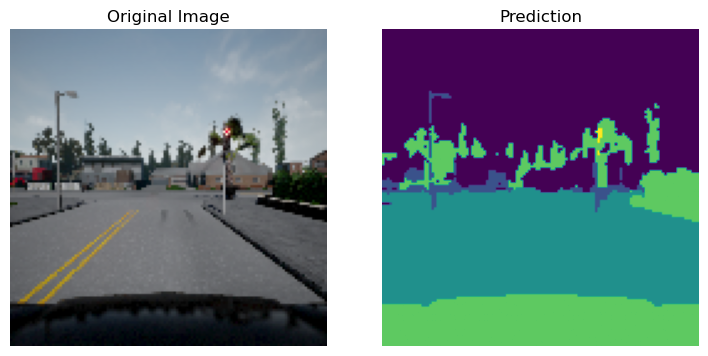

In [21]:
image_to_display = image[0].permute(1, 2, 0).numpy()
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_to_display)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(predictions[0][0].cpu().detach().numpy())
plt.title('Prediction')
plt.axis('off')

plt.tight_layout(pad=4.0)

plt.show()

In [ ]:
# import torch
# from unet import UNet

# model = UNet(in_channels=3, out_channels=1)
# input_tensor = torch.randn(1, 3, 256, 256)
# output_tensor = model(input_tensor)
# print(output_tensor)

